# Antiderivative SpectralSVR (Proof of concept)

In [1]:
import torch
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from skripsi_program import (
    SpectralSVR,
    FourierBasis,
    StandardScaler,
    Antiderivative,
)
from notebooks.utils import save_to_pgf

In [2]:
plt.rcParams.update(
    {
        # "text.usetex": True,  # use TeX for all texts
        "font.family": "serif",
        "font.size": 12,  # control font sizes of different elements
        # "pgf.rcfonts": False,    # don't setup fonts from rc parameters
    }
)

In [3]:
# Set seed
generator = torch.Generator().manual_seed(42)
# domain
domain = slice(0, 2, 500)
# Generate functions/data
n_coeffs = 5000
modes = 100
u0 = 0  # integration constant
problem = Antiderivative()
u_clean, f_clean = problem.generate(
    FourierBasis, n_coeffs, modes, u0, generator=generator, periods=2
)

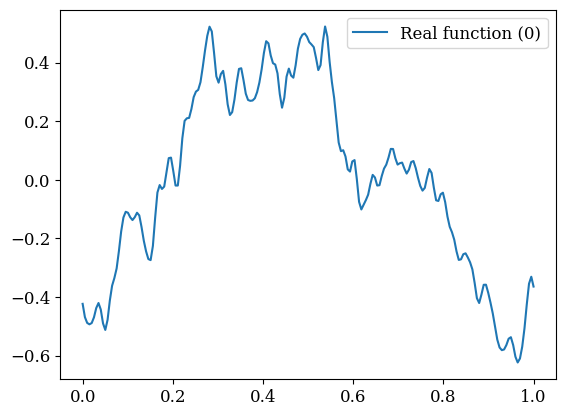

In [4]:
u_clean.plot()

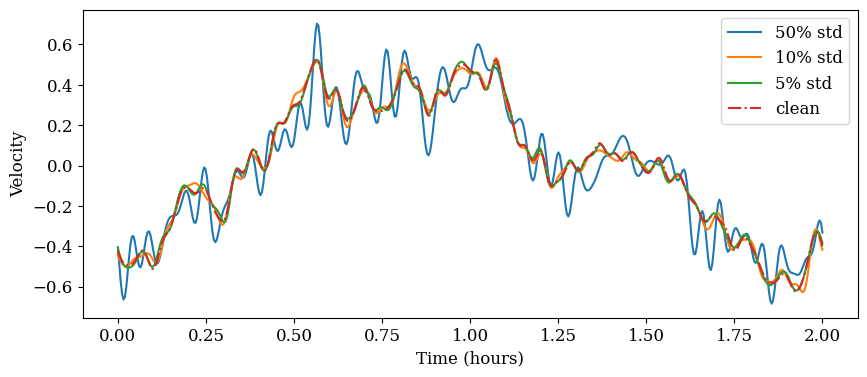

(100,)

In [5]:
# Add noise 1%
u_5 = u_clean.perturb(std_ratio=0.05, generator=generator)
f_5 = f_clean.perturb(std_ratio=0.05, generator=generator)
# Add noise 10%
u_10 = u_clean.perturb(std_ratio=0.10, generator=generator)
f_10 = f_clean.perturb(std_ratio=0.10, generator=generator)
# Add noise 50%
u_50 = u_clean.perturb(std_ratio=0.50, generator=generator)
f_50 = f_clean.perturb(std_ratio=0.50, generator=generator)


plt.figure(figsize=(10, 4))
u_50.plot(res=domain)
u_10.plot(res=domain)
u_5.plot(res=domain)
u_clean.plot(res=domain, linestyle="-.")
plt.xlabel("Time (hours)")
plt.ylabel("Velocity")
plt.legend(["50% std", "10% std", "5% std", "clean"], loc="upper right")
save_to_pgf("clean_perturbed_solution.pgf")
plt.show()
f_50.modes

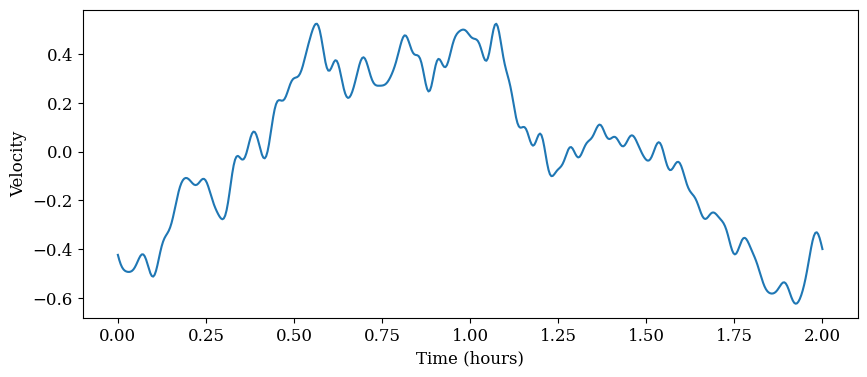

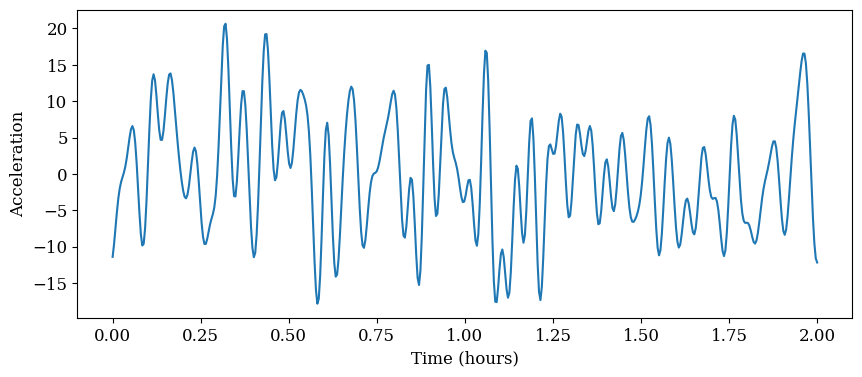

In [6]:
plt.figure(figsize=(10, 4))
u_clean.plot(i=0, res=domain, legend=False)
plt.xlabel("Time (hours)")
plt.ylabel("Velocity")
save_to_pgf("antiderivative_clean_0.pgf")
plt.show()
plt.figure(figsize=(10, 4))
f_clean.plot(i=0, res=domain, legend=False)
plt.xlabel("Time (hours)")
plt.ylabel("Acceleration")
save_to_pgf("derivative_clean_0.pgf")
plt.show()

In [7]:
# Train-test split
f_basis = f_50
u_basis = u_50
# Interpolate f & u
t = FourierBasis.grid(res=domain)
f = f_basis(t)
f = f.real

u = u_basis(t)
u = u.real
# df = TensorDataset(f, u, u_fourier.coeff)
df = TensorDataset(f, f_basis.coeff, u, u_basis.coeff)
df_train, df_test = random_split(
    df, (0.8, 0.2), generator=generator
)  # Scale inputs based on training inputs
f_train, f_coeff_train, u_train, u_coeff_train = df_train[:]
# f_input_train = f_train
f_input_train = f_coeff_train
scaler = StandardScaler().fit(f_input_train)
f_input_train = scaler.transform(f_input_train)
f_test, f_coeff_test, u_test, u_coeff_test = df_test[:]
# f_input_test = f_test
f_input_test = f_coeff_test
f_input_test = scaler.transform(f_input_test)

In [8]:
# Train svm
periods = (domain.stop - domain.start,)
model = SpectralSVR(
    FourierBasis(periods=periods),
    C=1.0,
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    verbose=None,
)
model.train(f_input_train, u_coeff_train)

In [9]:
model.svr.kernel_params.get("sigma")

tensor(14.1439, device='cuda:0')

In [10]:
# Test
model.test(f_input_test, u_coeff_test), model.test(f_input_test, u_clean.coeff[df_test.indices])

({'spectral': {'mse': 0.9576602578163147,
   'rmse': 0.9786011576652527,
   'mae': 0.6872550249099731,
   'r2': 0.21926486492156982,
   'smape': 1.3155498504638672,
   'rse': 0.7807376980781555,
   'rrse': 0.8673362135887146,
   'pred_nan_sum': 0},
  'function value': {'mse': 0.01909499801695347,
   'rmse': 0.13818465173244476,
   'mae': 0.11026754230260849,
   'r2': 0.6290455460548401,
   'smape': 0.9351093173027039,
   'rse': 0.3709544837474823,
   'rrse': 0.6089125275611877,
   'pred_nan_sum': 0}},
 {'spectral': {'mse': 0.4415096938610077,
   'rmse': 0.6644619703292847,
   'mae': 0.2898431718349457,
   'r2': 0.6199374198913574,
   'smape': 0.8869282603263855,
   'rse': 2066164.125,
   'rrse': 144.33055114746094,
   'pred_nan_sum': 0},
  'function value': {'mse': 0.008828400634229183,
   'rmse': 0.09395956993103027,
   'mae': 0.07501470297574997,
   'r2': 0.7864100933074951,
   'smape': 0.7641562223434448,
   'rse': 0.21358996629714966,
   'rrse': 0.4620433449745178,
   'pred_nan_sum

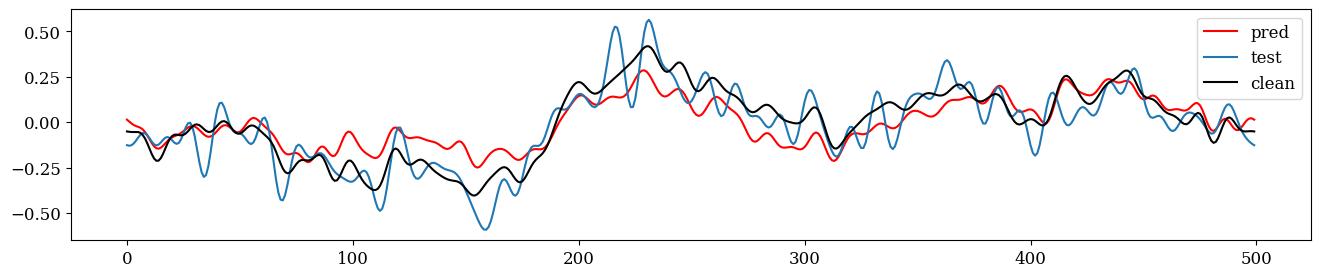

In [11]:
u_pred = model.forward(f_input_test, t, periods=periods).real
plt.figure(figsize=(16, 3))
# plt.plot(f_fourier[df_test.indices[0]](s).real[0], color="k")
i = 3
plt.plot(u_pred[i], color="r")
plt.plot(u_test[i])
plt.plot(u_clean[df_test.indices[i]](t)[0].real, color="k")
plt.legend(["pred","test","clean"])

(torch.Size([4000, 200]),
 torch.return_types.sort(
 values=tensor([-14.2385, -13.0991, -12.9656,  ...,  13.2700,  13.6636,  14.1354]),
 indices=tensor([ 170, 1903, 3371,  ..., 1421, 3482, 2737])))

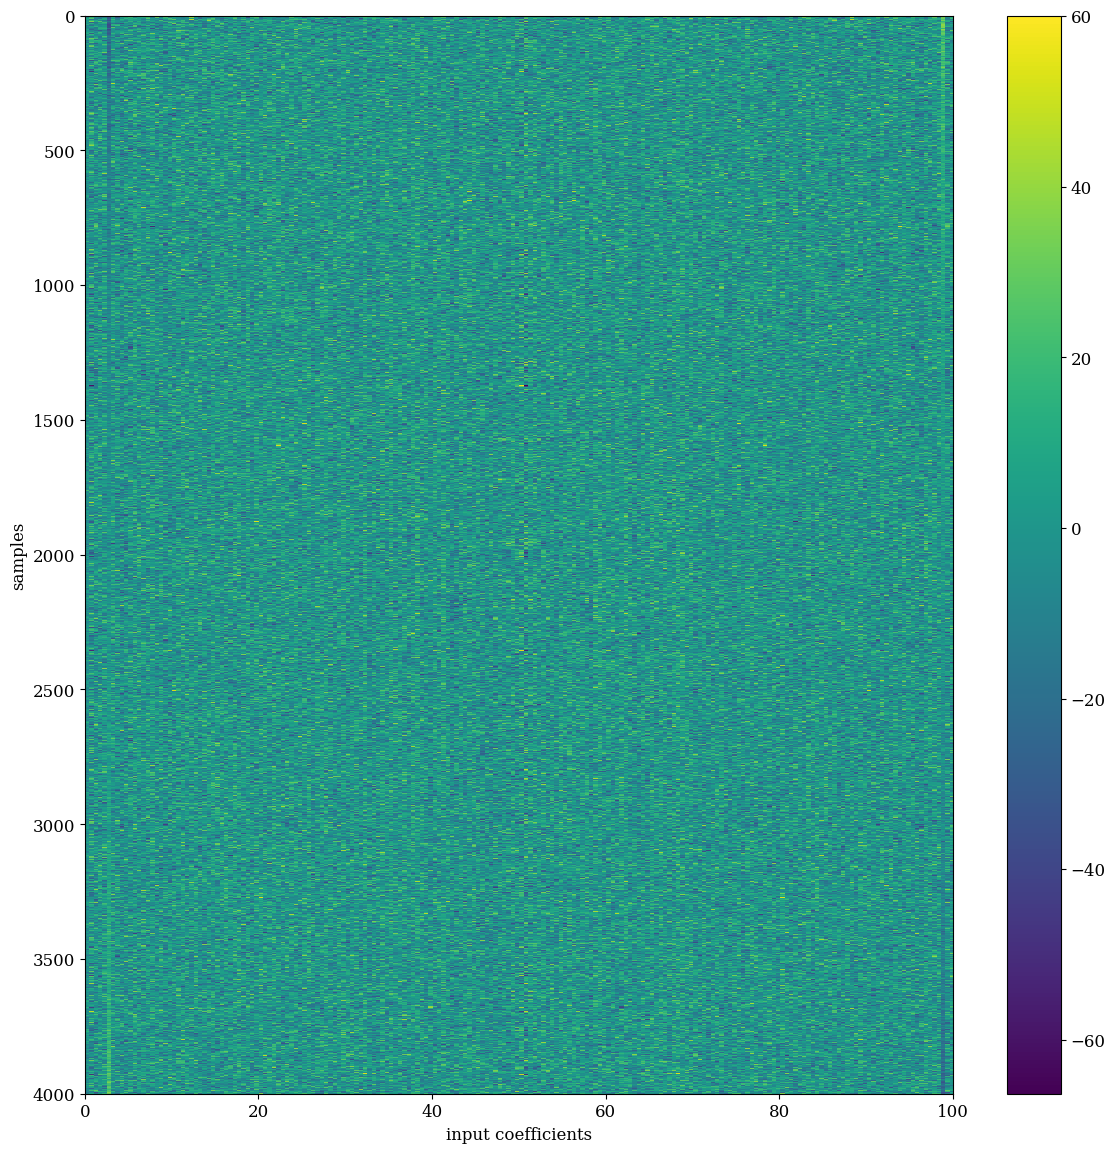

In [12]:
corr = model.svr.get_correlation_image().cpu()
sorted = u_coeff_train.real[:,2].sort()
plt.figure(figsize=(14, 14))
plt.imshow(corr[sorted.indices.cpu(), :], interpolation="none", aspect="auto",extent=(0,modes,corr.shape[0],0))
plt.ylabel("samples")
plt.xlabel("input coefficients")
plt.colorbar()
corr.shape, sorted


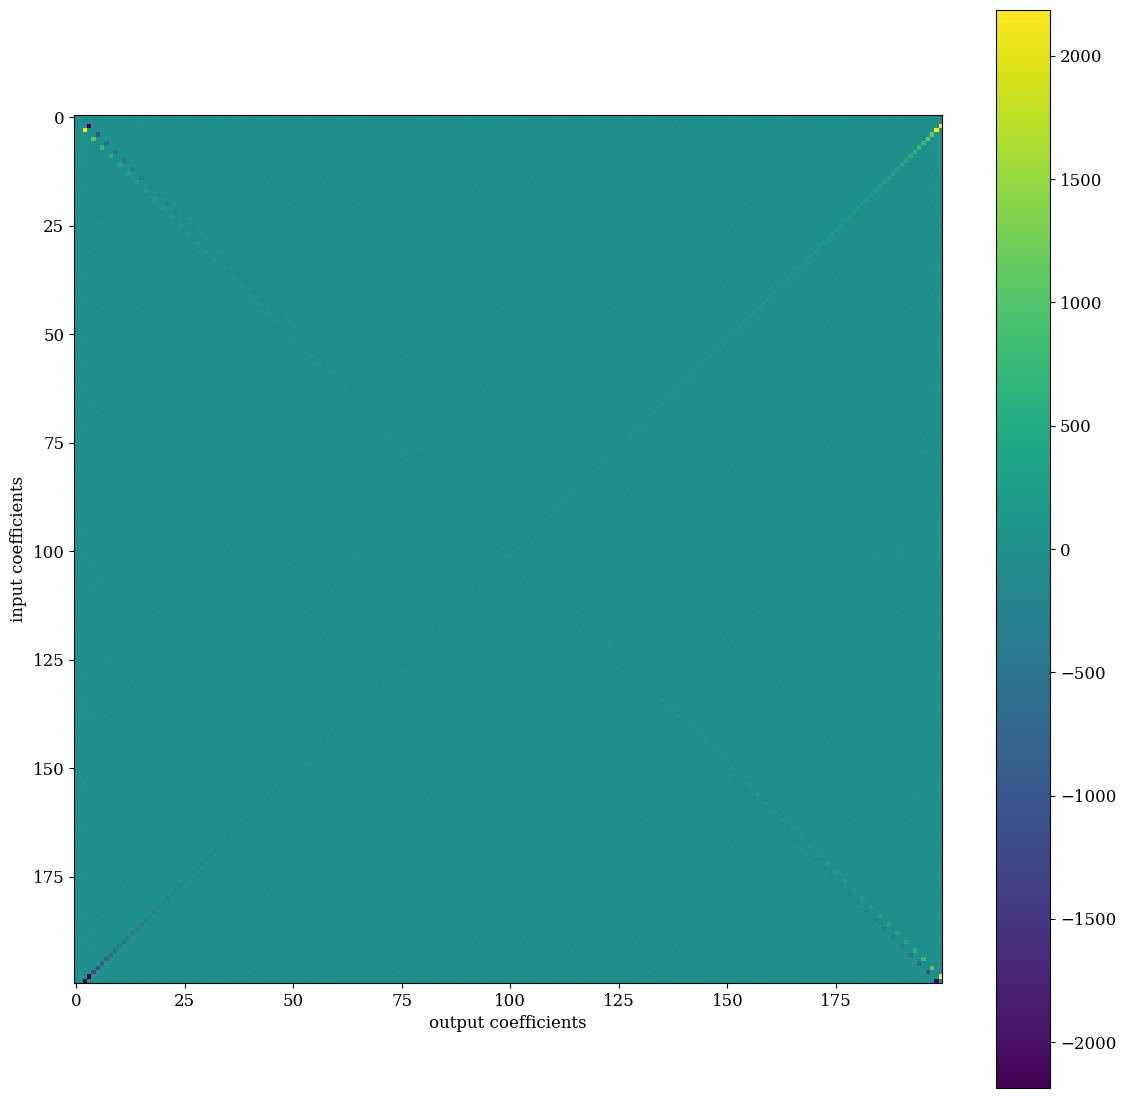

In [13]:
p_mat = model.svr.get_p_matrix().cpu()
plt.figure(figsize=(14,14))
plt.imshow(p_mat[:,:], interpolation="none", aspect="equal")
# plt.imshow(p_mat[:,2][:,None], interpolation="none", aspect="auto", extent=(0,10,0,10))
plt.colorbar()
plt.xlabel("output coefficients")
plt.ylabel("input coefficients")
plt.show()

In [14]:
u_clean[0].coeff, u_clean[0].grad().coeff

(tensor([[ 0.0000e+00+0.0000e+00j, -1.9465e+01-7.7623e+00j,
          -4.4808e+00+1.3981e+00j, -2.3777e+00-1.7245e+00j,
           3.6157e+00-1.4380e+00j, -2.3785e+00-3.5090e-01j,
          -3.4017e-03-2.7669e-01j,  5.1012e-01+2.1668e+00j,
           9.4370e-01-7.9027e-01j,  6.0158e-01+1.0212e+00j,
           1.5020e+00+9.5100e-01j,  9.6589e-01+2.4899e-03j,
           5.5137e-01-6.1660e-01j, -2.9944e-01-5.9992e-01j,
          -2.8736e-01+7.1482e-01j,  3.0295e-01-3.8911e-01j,
          -7.8220e-01+1.0504e+00j,  9.3053e-01+1.6068e-02j,
           9.5754e-02-1.8935e-01j, -1.2694e-01-9.7903e-02j,
           2.1581e-01+9.7294e-01j, -3.7874e-01+5.5607e-01j,
           6.4974e-01+9.6024e-01j, -5.1199e-01+4.1599e-01j,
          -3.8116e-01+1.3248e-01j,  9.4876e-02+1.4738e-01j,
           3.0337e-01+4.7290e-02j, -4.5570e-01-1.6781e-01j,
          -1.8538e-01+4.7747e-01j,  7.5314e-03+1.4555e-01j,
           1.5221e-01+8.8751e-02j,  8.3151e-02+5.4279e-01j,
           1.4733e-01-4.5484e-01j, -9.01

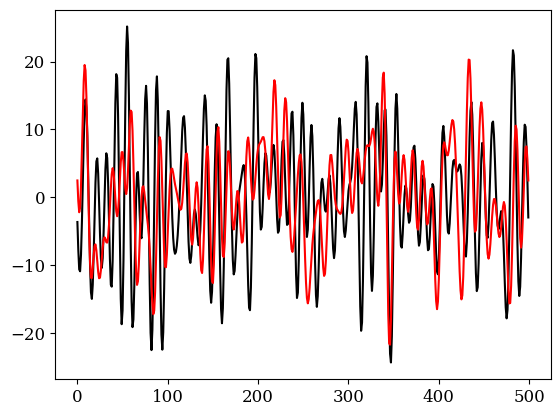

In [15]:
i= 0 
u_grad = torch.gradient(u_test[i], edge_order=2, spacing=t[1].sub(t[0]).item())[0]
plt.plot(u_grad, color="k")
# plt.plot(u_test[0])
plt.plot(f_test[i].real, color="r", linestyle="-")


In [16]:
# Test CPU
model = SpectralSVR(
    FourierBasis(periods=periods), C=1.0, device=torch.device("cpu"), verbose=None
)
%timeit model.train(f_train, u_coeff_train)
%timeit model.test(f_test,u_coeff_test)


1.32 s ± 69.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
55.7 ms ± 711 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
# Test GPU
model = SpectralSVR(
    FourierBasis(periods=periods), C=1.0, device=torch.device("cuda:0"), verbose=None
)
%timeit model.train(f_train, u_coeff_train)
%timeit model.test(f_test,u_coeff_test)

147 ms ± 8.48 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
